In [1]:
import os, sys
import argparse
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math, re
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf

# user functions
from dataUtils import loadEnergyData, processData, energyDataset
from modelUtils import saveCheckpoint, loadCheckpoint, plotPredVsTrue, dotDict


In [2]:
# last three months - test set
test_range = ["2014-10-01 00:00:00", "2014-12-31 23:00:00"]
test_range = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in test_range]# data directories
processed_dir = "./data/"



In [3]:
energy_demand, adj_mat = loadEnergyData(processed_dir, incl_nodes = 300, partial = False)
#bacis preprocessing and normalization
energy_demand = processData(energy_demand)

In [4]:
energy_demand

,time,node,hour,dow,month,year,holiday,season,country,voltage,solar_ecmwf,wind_ecmwf,load
0,2012-01-01 00:00:00,1,0,6,1,2012,1,3,2,380,0.0,0.0284,0.279887
1,2012-01-01 01:00:00,1,1,6,1,2012,1,3,2,380,0.0,0.0336,0.218439
2,2012-01-01 02:00:00,1,2,6,1,2012,1,3,2,380,0.0,0.0392,0.160968
3,2012-01-01 03:00:00,1,3,6,1,2012,1,3,2,380,0.0,0.0424,0.112879
4,2012-01-01 04:00:00,1,4,6,1,2012,1,3,2,380,0.0,0.0475,0.087529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891195,2014-12-31 19:00:00,300,19,2,12,2014,0,3,1,380,0.0,0.2457,0.614737
7891196,2014-12-31 20:00:00,300,20,2,12,2014,0,3,1,380,0.0,0.2605,0.567729
7891197,2014-12-31 21:00:00,300,21,2,12,2014,0,3,1,380,0.0,0.2924,0.541257
7891198,2014-12-31 22:00:00,300,22,2,12,2014,0,3,1,380,0.0,0.2836,0.608209


In [5]:
energy_demand['time'] = pd.to_datetime(energy_demand['time'], format='%Y-%m-%d %H:%M:%S')
    
    # extract validation and training sets
train_df = energy_demand[energy_demand['time'] < test_range[0]].reset_index(drop = True)
test_df = energy_demand[(energy_demand['time'] >= test_range[0]) & 
                           (energy_demand['time'] <= test_range[1])].reset_index(drop = True)

In [6]:
train_df = train_df[['node','time','load']]
test_df = test_df[['node','time','load']]

In [7]:
test_df

,node,time,load
0,1,2014-10-01 00:00:00,0.219127
1,1,2014-10-01 01:00:00,0.179738
2,1,2014-10-01 02:00:00,0.169309
3,1,2014-10-01 03:00:00,0.162040
4,1,2014-10-01 04:00:00,0.175378
...,...,...,...
655771,300,2014-12-31 19:00:00,0.614737
655772,300,2014-12-31 20:00:00,0.567729
655773,300,2014-12-31 21:00:00,0.541257
655774,300,2014-12-31 22:00:00,0.608209


In [8]:
node_num = max(train_df.node)
node_num

300

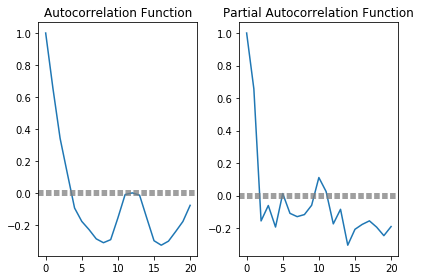

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


time
2014-10-27 00:00:00    0.218924
2014-10-27 01:00:00    0.177129
2014-10-27 02:00:00    0.149347
2014-10-27 03:00:00    0.134670
2014-10-27 04:00:00    0.107527
2014-10-27 05:00:00    0.135242
2014-10-27 06:00:00    0.166884
2014-10-27 07:00:00    0.199099
2014-10-27 08:00:00    0.327400
2014-10-27 09:00:00    0.450259
2014-10-27 10:00:00    0.493240
2014-10-27 11:00:00    0.519437
2014-10-27 12:00:00    0.544917
2014-10-27 13:00:00    0.490884
2014-10-27 14:00:00    0.514691
2014-10-27 15:00:00    0.530654
2014-10-27 16:00:00    0.549037
2014-10-27 17:00:00    0.562389
2014-10-27 18:00:00    0.610452
2014-10-27 19:00:00    0.659129
2014-10-27 20:00:00    0.637626
2014-10-27 21:00:00    0.551074
2014-10-27 22:00:00    0.484985
2014-10-27 23:00:00    0.401702
Name: load, dtype: float64


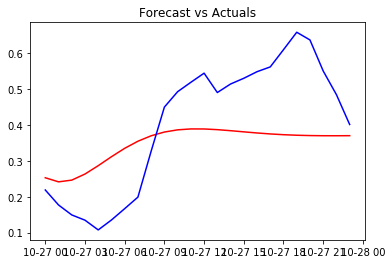

In [43]:
#time zone = 50, node =1
ts = train_df[train_df['node']==2]
ts.set_index('time', inplace=True)
ts = ts.load
sub_test = test_df[test_df['node']==2]
sub_test.set_index('time',inplace=True)
sub_test = sub_test.load
ts = pd.concat([ts,sub_test[0:12*52]])
#parameter d = 1
ts_diff=ts-ts.shift()
plt.plot(ts_diff)
ts_diff.dropna(inplace = True)
# find parameter p=2&q=4
lag_acf = acf(ts_diff,nlags=20)
lag_pacf = pacf(ts_diff,nlags = 20,method='ols')
#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')  # lowwer CI
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')  # upper CI
plt.title('Autocorrelation Function')
#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()
      
#model
model = ARIMA(ts,order = (2,1,4))
model_fit = model.fit(disp=-1)
fc, se, conf = model_fit.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=sub_test.index[12*52:12*52+24])
ARIMA_predicted_50_1=fc_series
#print(fc_series)
plt.plot(fc_series, label='forecast',color='red')
print(sub_test[12*52:12*52+24])
plt.plot(sub_test[12*52:12*52+24], label='actual',color='blue')
plt.title('Forecast vs Actuals')
plt.show()

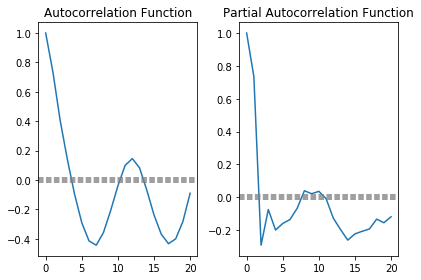

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


time
2014-10-02 00:00:00    0.237229
2014-10-02 01:00:00    0.206399
2014-10-02 02:00:00    0.199401
2014-10-02 03:00:00    0.189449
2014-10-02 04:00:00    0.203212
2014-10-02 05:00:00    0.286642
2014-10-02 06:00:00    0.417269
2014-10-02 07:00:00    0.483049
2014-10-02 08:00:00    0.516795
2014-10-02 09:00:00    0.545409
2014-10-02 10:00:00    0.560415
2014-10-02 11:00:00    0.587513
2014-10-02 12:00:00    0.595793
2014-10-02 13:00:00    0.543970
2014-10-02 14:00:00    0.522082
2014-10-02 15:00:00    0.522821
2014-10-02 16:00:00    0.522588
2014-10-02 17:00:00    0.511197
2014-10-02 18:00:00    0.515279
2014-10-02 19:00:00    0.596765
2014-10-02 20:00:00    0.572778
2014-10-02 21:00:00    0.456380
2014-10-02 22:00:00    0.354522
2014-10-02 23:00:00    0.291230
Name: load, dtype: float64


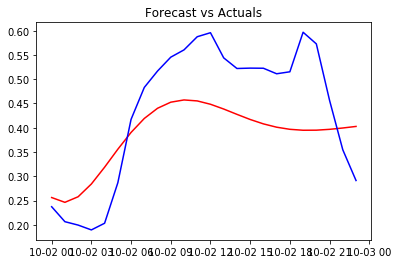

In [42]:
#time zone = 0, node =100
ts = train_df[train_df['node']==101]
ts.set_index('time', inplace=True)
ts = ts.load
sub_test = test_df[test_df['node']==101]
sub_test.set_index('time',inplace=True)
sub_test = sub_test.load
ts = pd.concat([ts,sub_test[0:24]])

#parameter d = 1
ts_diff=ts-ts.shift()
plt.plot(ts_diff)
ts_diff.dropna(inplace = True)
# find parameter p=2&q=4
lag_acf = acf(ts_diff,nlags=20)
lag_pacf = pacf(ts_diff,nlags = 20,method='ols')
#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')  # lowwer CI
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')  # upper CI
plt.title('Autocorrelation Function')
#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()
      
#model
model = ARIMA(ts,order = (2,1,4))
model_fit = model.fit(disp=-1)
fc, se, conf = model_fit.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=sub_test.index[24:48])
ARIMA_predicted_0_100=fc_series
#print(fc_series)
plt.plot(fc_series, label='forecast',color='red')
print(sub_test[24:48])
plt.plot(sub_test[24:48], label='actual',color='blue')
plt.title('Forecast vs Actuals')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


time
2014-10-06 12:00:00    0.502387
2014-10-06 13:00:00    0.518808
2014-10-06 14:00:00    0.546114
2014-10-06 15:00:00    0.560245
2014-10-06 16:00:00    0.570173
2014-10-06 17:00:00    0.523200
2014-10-06 18:00:00    0.531984
2014-10-06 19:00:00    0.658391
2014-10-06 20:00:00    0.586595
2014-10-06 21:00:00    0.516136
2014-10-06 22:00:00    0.427726
2014-10-06 23:00:00    0.329769
2014-10-07 00:00:00    0.264846
2014-10-07 01:00:00    0.226465
2014-10-07 02:00:00    0.208516
2014-10-07 03:00:00    0.190567
2014-10-07 04:00:00    0.181973
2014-10-07 05:00:00    0.203933
2014-10-07 06:00:00    0.272484
2014-10-07 07:00:00    0.352492
2014-10-07 08:00:00    0.502960
2014-10-07 09:00:00    0.537522
2014-10-07 10:00:00    0.560626
2014-10-07 11:00:00    0.582776
Name: load, dtype: float64


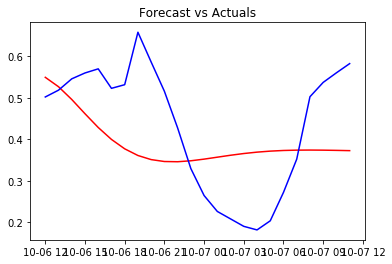

In [45]:
#time zone = 9, node =8
ts = train_df[train_df['node']==9]
ts.set_index('time', inplace=True)
ts = ts.load
sub_test = test_df[test_df['node']==9]
sub_test.set_index('time',inplace=True)
sub_test = sub_test.load
ts = pd.concat([ts,sub_test[0:12*11]])    
#model
model = ARIMA(ts,order = (2,1,4))
model_fit = model.fit(disp=-1)
fc, se, conf = model_fit.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=sub_test.index[12*11:12*11+24])
ARIMA_predicted_9_8=fc_series
#print(fc_series)
plt.plot(fc_series, label='forecast',color='red')
print(sub_test[12*11:12*11+24])
plt.plot(sub_test[12*11:12*11+24], label='actual',color='blue')
plt.title('Forecast vs Actuals')
plt.show()

In [50]:
ARIMA_predicted_50_1.values
ARIMA_Result = {'ARIMA_50_1':ARIMA_predicted_50_1.values,
               'ARIMA_0_100':ARIMA_predicted_0_100.values,
               'ARIMA_9_8':ARIMA_predicted_9_8.values}
ARIMA_Result = pd.DataFrame(ARIMA_Result)
ARIMA_Result.to_csv('ARIMA_Reuslt.csv')